In [1]:
import copy
from collections import defaultdict

import gymnasium
from gymnasium.envs.toy_text.cliffwalking import (
    UP, RIGHT, DOWN, LEFT, POSITION_MAPPING
)
import numpy as np
import tqdm
from IPython import display
from PIL import Image, ImageEnhance
import moviepy.editor as mpy
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


In [2]:
class CliffWalkingEnv(gymnasium.Wrapper):
    def __init__(self, random_init_state=False, max_episode_steps=1000, 
                 render_mode="rgb_array", **kwargs):
        env = gymnasium.make(
            "CliffWalking-v1",
            max_episode_steps=max_episode_steps,
            render_mode=render_mode,
            **kwargs
        )
        super().__init__(env)

        self.nS = self.env.get_wrapper_attr('nS')
        self.nA = self.env.get_wrapper_attr('nA')
        self.shape = self.env.get_wrapper_attr('shape')

        # The original transition probabilities for absorbing states are not correct.
        P = {}
        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            P[s] = {a: [] for a in range(self.nA)}
            P[s][UP] = self._calculate_transition_prob(position, UP)
            P[s][RIGHT] = self._calculate_transition_prob(position, RIGHT)
            P[s][DOWN] = self._calculate_transition_prob(position, DOWN)
            P[s][LEFT] = self._calculate_transition_prob(position, LEFT)
        self.env.set_wrapper_attr('P', P)

        if random_init_state:
            initial_state_distrib = np.ones(self.nS)
            cliff_positions = np.asarray(np.where(env.get_wrapper_attr('_cliff')))
            cliff_states = np.ravel_multi_index(cliff_positions, self.shape)
            initial_state_distrib[cliff_states] = 0.0
            initial_state_distrib[47] = 0.0
            initial_state_distrib /= np.sum(initial_state_distrib, keepdims=True)
            self.env.set_wrapper_attr('initial_state_distrib', initial_state_distrib)

        # Calculate transition probabilities and rewards
        rewards = np.full((self.nS, self.nA, self.nS), np.nan)
        transition_probs = np.zeros((self.nS, self.nA, self.nS))
        masks = np.zeros((self.nS, self.nA, self.nS))
        for state in range(self.nS):
            for action in range(self.nA):
                _, next_state, reward, terminated = self.env.get_wrapper_attr('P')[state][action][0]
                rewards[state, action, next_state] = reward
                transition_probs[state, action, next_state] += 1.0
                masks[state, action, next_state] = float(not terminated)
        transition_probs /= np.sum(transition_probs, axis=-1, keepdims=True)
        assert np.all(np.sum(transition_probs, axis=-1) == 1.0)
        reward_max, reward_min = np.nanmax(rewards), np.nanmin(rewards)
        rewards[np.isnan(rewards)] = reward_min
        assert np.all((reward_min <= rewards) & (rewards <= reward_max))

        self._orig_reward_min, self._orig_reward_max = reward_min, reward_max
        self.orig_rewards = rewards
        self.rewards = (rewards - reward_min) / (reward_max - reward_min)
        self.transition_probs = transition_probs
        self.masks = masks

    def _calculate_transition_prob(self, current, move):
        """Determine the outcome for an action. Transition Prob is always 1.0.
        
        The original transition probabilities for absorbing states are not correct.
        """
        if not self.env.get_wrapper_attr('is_slippery'):
            deltas = [POSITION_MAPPING[move]]
        else:
            deltas = [
                POSITION_MAPPING[act] for act in [(move - 1) % 4, move, (move + 1) % 4]
            ]
        outcomes = []

        # the single absorbing state is the goal
        goal_position = np.asarray([self.shape[0] - 1, self.shape[1] - 1])
        goal_state = np.ravel_multi_index(goal_position, self.shape)
        current_position = np.array(current)
        current_state = np.ravel_multi_index(tuple(current_position), self.shape)
        for delta in deltas:
            if current_state == goal_state:
                new_state = current_state
                reward = 100
                is_terminated = True
            else:
                new_position = current_position + np.array(delta)
                new_position = self.env.get_wrapper_attr('_limit_coordinates')(new_position).astype(int)
                new_state = np.ravel_multi_index(tuple(new_position), self.shape)
                if self.env.get_wrapper_attr('_cliff')[tuple(new_position)]:
                    reward = -100
                    new_state = self.env.get_wrapper_attr('start_state_index')
                else:
                    reward = -1
                is_terminated = (new_state == goal_state)
            outcomes.append((1 / len(deltas), new_state, reward, is_terminated))
        return outcomes

    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs)
        self.env.set_wrapper_attr('start_state_index', obs)

        return obs, info

    def step(self, action):
        obs, orig_reward, terminated, truncated, info = super().step(action)
        reward = (orig_reward - self._orig_reward_min) / (self._orig_reward_max - self._orig_reward_min)

        return obs, reward, terminated, truncated, info


In [3]:
# collect dataset
discount = 0.95
max_episode_steps = 100
env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)

# uniform behavioral policy
behavioral_policy = np.ones([env.nS, env.nA]) / env.nA

dataset = defaultdict(list)

# dataset size = 100K
# num_episodes = 5_250
num_episodes = 1_000
num_transitions = 0
for _ in tqdm.trange(num_episodes):
    # done = False
    obs, info = env.reset()
    # while not done:
    for _ in range(max_episode_steps):
        action = np.random.choice(np.arange(env.nA), p=behavioral_policy[obs])
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        num_transitions += 1
        dataset['observations'].append(obs)
        dataset['actions'].append(action)
        dataset['rewards'].append(reward)
        dataset['next_observations'].append(next_obs)
        dataset['masks'].append(not terminated)  # for absorbing states
        dataset['terminals'].append(truncated)  # for the end of trajectories
        
        obs = next_obs

for k, v in dataset.items():
    if k in ['observations', 'actions', 'next_observations']:
        dtype = np.int32
    elif k == 'terminals':
        dtype = bool
    else:
        dtype = np.float32
    dataset[k] = np.array(v, dtype=dtype)

print("num of total transitions {}".format(num_transitions))

100%|██████████| 1000/1000 [00:02<00:00, 366.36it/s]

num of total transitions 100000


In [4]:
print(np.sum(dataset['next_observations'] == 47))

6712


In [5]:
# value iteration to find the optimal Q
rewards = env.rewards
transition_probs = env.transition_probs
# masks = env.masks

# value iteration to find the optimal Q in the original MDP using gamma
opt_q = np.zeros([env.nS, env.nA], dtype=np.float32)
for _ in range(10_000):
  opt_q = (1 - discount) * np.sum(transition_probs * rewards, axis=-1) + discount * np.einsum('ijk,k->ij', transition_probs, np.max(opt_q, axis=-1))
opt_v = np.max(opt_q, axis=-1)

# deterministic optimal policy
opt_policy = np.zeros([env.nS, env.nA])
opt_policy[np.arange(env.nS), np.argmax(opt_q, axis=-1)] = 1.0

# value iteration to find the optimal Q in the original MDP using gamma ** 2
opt_q_square_discount = np.zeros([env.nS, env.nA], dtype=np.float32)
for _ in range(10_000):
  opt_q_square_discount = (1 - discount ** 2) * np.sum(transition_probs * rewards, axis=-1) + discount ** 2 * np.einsum('ijk,k->ij', transition_probs, np.max(opt_q_square_discount, axis=-1))

# value iteration to find the behavioral Q
behavioral_q = np.zeros([env.nS, env.nA], dtype=np.float32)
for _ in range(10_000):
  behavioral_q = (1 - discount) * np.sum(transition_probs * rewards, axis=-1) + discount * np.einsum('ijk,k->ij', transition_probs, np.sum(behavioral_policy * behavioral_q, axis=-1))
behavioral_v = np.sum(behavioral_policy * behavioral_q, axis=-1)

In [6]:
print("optimal q and optimal policy: ")
print(opt_q)
print(opt_policy)

print("behavioral q: ")
print(behavioral_q)

optimal q and optimal policy: 
[[0.72896207 0.74127586 0.74127586 0.72896207]
 [0.74127586 0.75423775 0.75423775 0.72896207]
 [0.75423775 0.76788184 0.76788184 0.74127586]
 [0.76788184 0.78224405 0.78224405 0.75423775]
 [0.78224405 0.79736215 0.79736215 0.76788184]
 [0.79736215 0.81327595 0.81327595 0.78224405]
 [0.81327595 0.83002732 0.83002732 0.79736215]
 [0.83002732 0.84766033 0.84766033 0.81327595]
 [0.84766033 0.8662214  0.8662214  0.83002732]
 [0.8662214  0.88575937 0.88575937 0.84766033]
 [0.88575937 0.90632566 0.90632566 0.8662214 ]
 [0.90632566 0.90632566 0.92797437 0.88575937]
 [0.72896207 0.75423775 0.75423775 0.74127586]
 [0.74127586 0.76788184 0.76788184 0.74127586]
 [0.75423775 0.78224405 0.78224405 0.75423775]
 [0.76788184 0.79736215 0.79736215 0.76788184]
 [0.78224405 0.81327595 0.81327595 0.78224405]
 [0.79736215 0.83002732 0.83002732 0.79736215]
 [0.81327595 0.84766033 0.84766033 0.81327595]
 [0.83002732 0.8662214  0.8662214  0.83002732]
 [0.84766033 0.88575937 0.885

In [7]:
def get_video(renders):
    """Return a Weights & Biases video.

    It takes a list of videos and reshapes them into a single video with the specified number of columns.

    Args:
        renders: List of videos. Each video should be a numpy array of shape (t, h, w, c).
        n_cols: Number of columns for the reshaped video. If None, it is set to the square root of the number of videos.
    """
    # Pad videos to the same length.
    max_length = max([len(render) for render in renders])
    for i, render in enumerate(renders):
        assert render.dtype == np.uint8

        # Decrease brightness of the padded frames.
        final_frame = render[-1]
        final_image = Image.fromarray(final_frame)
        enhancer = ImageEnhance.Brightness(final_image)
        final_image = enhancer.enhance(0.5)
        final_frame = np.array(final_image)

        pad = np.repeat(final_frame[np.newaxis, ...], max_length - len(render), axis=0)
        renders[i] = np.concatenate([render, pad], axis=0)

        # Add borders.
        renders[i] = np.pad(renders[i], ((0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)
    renders = np.array(renders)  # (n, t, h, w, c)

    return renders

In [8]:
# evaluation the optimal pi
max_episode_steps = 100
eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)

num_episodes = 6
successes = []
renders = []
for _ in tqdm.trange(num_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, info = eval_env.reset()
    render = eval_env.render().copy()
    while not done:
        action = np.random.choice(np.arange(eval_env.nA), p=opt_policy[obs])
        next_obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        next_render = eval_env.render().copy()
        
        traj_dataset['observations'].append(obs)
        traj_dataset['actions'].append(action)
        traj_dataset['rewards'].append(reward)
        traj_dataset['next_observations'].append(next_obs)
        traj_dataset['renders'].append(render)
        
        obs = next_obs
        render = next_render
    traj_dataset['renders'].append(render)  # append the last frame
    
    successes.append(47 in traj_dataset['next_observations'])
    renders.append(np.asarray(traj_dataset['renders']))

sr = np.mean(successes)
print("success rate = {}".format(sr))

videos = get_video(renders)

fps = 15
num_rows = 2
num_cols = 3
clip_array = []
for row in range(num_rows):
    clip_row = []
    for col in range(num_cols):
        idx = row * num_cols + col
        
        clip = mpy.ImageSequenceClip(list(videos[idx]), fps=fps)
        clip_row.append(clip)
    clip_array.append(clip_row)

clip_array = mpy.clips_array(clip_array)
clip_array.ipython_display(fps=fps, loop=True, autoplay=True)


100%|██████████| 6/6 [00:00<00:00, 31.48it/s]


success rate = 1.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


#### Utils

In [25]:
(terminal_locs,) = np.nonzero(dataset['terminals'] > 0)
assert terminal_locs[-1] == (len(dataset['observations']) - 1)

def sample_batch(batch_size, p_curgoal=0.2, p_trajgoal=0.5, relabel_reward=False):
    dataset_size = len(dataset['observations'])
    idxs = np.random.randint(dataset_size, size=batch_size)
    batch = jax.tree_util.tree_map(lambda arr: arr[idxs], dataset)
    
    final_state_idxs = terminal_locs[np.searchsorted(terminal_locs, idxs)]
    
    offsets = np.random.geometric(p=1 - discount, size=batch_size)  # in [1, inf)
    traj_goal_idxs = np.minimum(idxs + offsets, final_state_idxs)
    random_goal_idxs = np.random.randint(dataset_size, size=batch_size)
    goal_idxs = np.where(
        np.random.rand(batch_size) < p_trajgoal / (1.0 - p_curgoal), traj_goal_idxs, random_goal_idxs
    )
    goal_idxs = np.where(np.random.rand(batch_size) < p_curgoal, idxs, goal_idxs)
    
    batch['goals'] = jax.tree_util.tree_map(lambda arr: arr[goal_idxs], dataset['observations'])
    batch['goal_actions'] = jax.tree_util.tree_map(lambda arr: arr[goal_idxs], dataset['actions'])
    if relabel_reward:
        successes = (idxs == goal_idxs).astype(float)
        batch['masks'] = 1.0 - successes
        batch['rewards'] = successes - 1.0  # 0 for goal and -1 for other states
    
    return batch

In [26]:
def plot_metrics(metrics, logyscale_stats=[], title=''):
  # learning curves
  nrows = np.ceil(len(metrics) / 4).astype(int)
  ncols = 4
  f, axes = plt.subplots(nrows=nrows, ncols=ncols)
  if nrows == 1:
    axes = np.array([axes])
  f.set_figheight(3 * nrows)
  f.set_figwidth(3 * ncols)

  for idx, (name, val) in enumerate(metrics.items()):
    v = np.array(val)
    if len(v) == 0:
      continue

    x, y = v[:, 0], v[:, 1]
    ax = axes[idx // 4, idx % 4]

    if 'train' in name:
      y = gaussian_filter1d(y, 100)
    ax.plot(x, y)
    if name in logyscale_stats:
      ax.set_yscale('log')
    ax.set_title(name)

    ax.grid()

  f.suptitle(title)

  return f

### Q-Learning

In [21]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, env.nS)
    action = jax.nn.one_hot(action, env.nA)
    inputs = jnp.concatenate([obs, action], axis=-1)
    # inputs = jnp.ravel_multi_index(jnp.stack([obs, action], axis=-1).T, (env.nS, env.nA))
    # inputs = obs * env.nA + action
    # inputs = jax.nn.one_hot(inputs, env.nS * env.nA)

    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    # qs = nn.Dense(1,  use_bias=False)(inputs)
    
    qs = qs.squeeze(-1)

    return qs

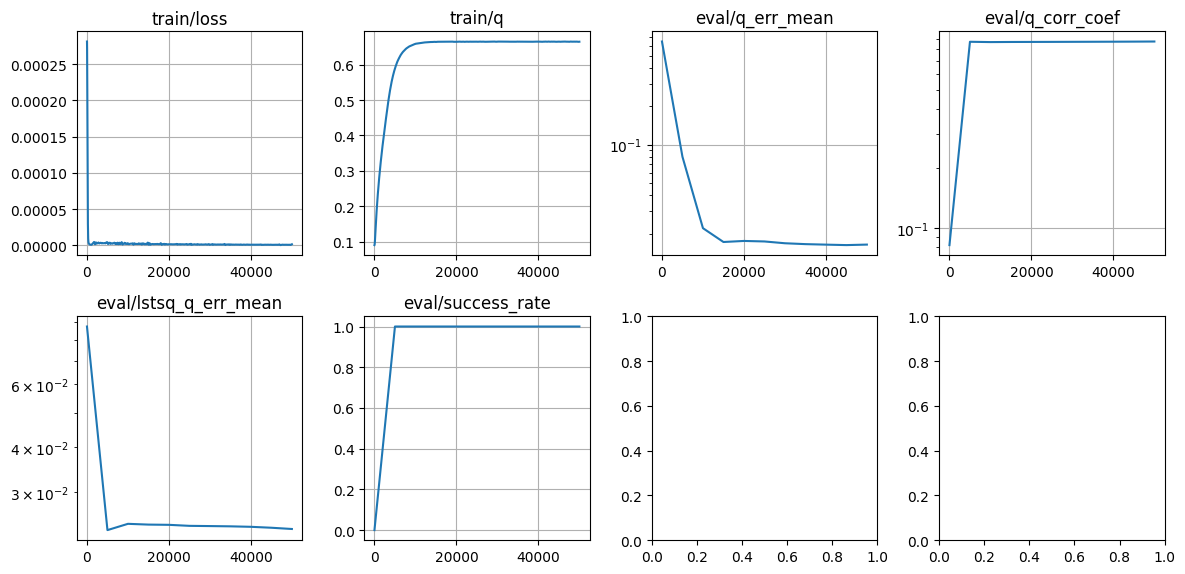

100%|██████████| 50000/50000 [00:50<00:00, 989.67it/s] 


In [22]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_batch(2)
critic = Critic()
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'])
  
  next_observations = batch['next_observations'][:, None].repeat(env.nA, axis=1).reshape(-1)
  next_actions = jnp.arange(env.nA)[None, :].repeat(batch_size, axis=0).reshape(-1)
  next_qs = critic.apply(target_params, next_observations, next_actions)
  next_qs = next_qs.reshape([batch_size, env.nA])
  next_q = jnp.max(next_qs, axis=-1)
  target_q = (1 - discount ** 2) * batch['rewards'] + discount ** 2 * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=200, max_episode_steps=100):
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(eval_env.nS)[:, None].repeat(eval_env.nA, axis=1).reshape(-1)
  actions = jnp.arange(eval_env.nA)[None, :].repeat(eval_env.nS, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([eval_env.nS, eval_env.nA])
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, eval_env.nA)
  pi = np.asarray(pi)

  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(eval_env.nA), p=pi[obs])
      next_obs, reward, terminated, truncated, _ = eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)

  # evaluation
  # aug_successes = []
  # for _ in tqdm.trange(num_eval_episodes):
  #   traj_dataset = defaultdict(list)

  #   done = False
  #   obs, _ = aug_eval_env.reset()
  #   while not done:
  #     action = np.random.choice(np.arange(aug_eval_env.nA), p=pi[obs])
  #     next_obs, reward, terminated, truncated, _ = aug_eval_env.step(action)
  #     done = terminated or truncated
      
  #     traj_dataset['observations'].append(obs)
  #     traj_dataset['actions'].append(action)
  #     traj_dataset['rewards'].append(reward)
  #     traj_dataset['next_observations'].append(next_obs)
      
  #     obs = next_obs
  #   aug_successes.append(48 in traj_dataset['next_observations'])
  # aug_sr = np.mean(aug_successes)
  aug_sr = 0.0

  return sr, aug_sr

def evaluate_fn(params):
  obs = jnp.arange(env.nS)[:, None].repeat(env.nA, axis=1).reshape(-1)
  actions = jnp.arange(env.nA)[None, :].repeat(env.nS, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([env.nS, env.nA])
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr, _ = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [23]:
q_learning_metrics = metrics
print(q_learning_metrics['eval/q_err_mean'][-1])
print(q_learning_metrics['eval/q_corr_coef'][-1])
print(q_learning_metrics['eval/lstsq_q_err_mean'][-1])
print(q_learning_metrics['eval/success_rate'][-1])

[5.00000000e+04 1.63616948e-02]
[5.00000000e+04 8.77861857e-01]
[5.0000000e+04 2.3637671e-02]
[5.e+04 1.e+00]


### QRL

In [27]:
class LogParam(nn.Module):
  """Scalar parameter module with log scale."""

  init_value: float = 1.0

  @nn.compact
  def __call__(self):
    log_value = self.param('log_value', init_fn=lambda key: jnp.full((), jnp.log(self.init_value)))
    return log_value

class MRNValue(nn.Module):
  repr_dim: int = 512

  @nn.compact
  def __call__(self, obs, actions, goals, goal_actions):
    obs = jax.nn.one_hot(obs, env.nS)
    actions = jax.nn.one_hot(actions, env.nA)
    goals = jax.nn.one_hot(goals, env.nS)
    goal_actions = jax.nn.one_hot(goal_actions, env.nA)

    phi_net = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])
    
    phi_s = phi_net(jnp.concatenate([obs, actions], axis=-1))
    phi_g = phi_net(jnp.concatenate([goals, goal_actions], axis=-1))
    
    sym_s = phi_s[..., : self.repr_dim // 2]
    sym_g = phi_g[..., : self.repr_dim // 2]
    asym_s = phi_s[..., self.repr_dim // 2:]
    asym_g = phi_g[..., self.repr_dim // 2:]
    squared_dist = ((sym_s - sym_g) ** 2).sum(axis=-1)
    quasi = jax.nn.relu((asym_s - asym_g).max(axis=-1))
    v = jnp.sqrt(jnp.maximum(squared_dist, 1e-12)) + quasi

    return v

In [ ]:
batch_size = 1024
tau = 0.005
eps = 0.05  # Margin for the dual lambda loss.
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

transition_probs = jnp.asarray(env.transition_probs)
transition_probs = jnp.concatenate([
  transition_probs, 
  jnp.zeros_like(transition_probs[..., [0]]), 
  jnp.zeros_like(transition_probs[..., [0]])
], axis=-1)

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, quasi_value_key, log_lam_key = jax.random.split(key, 3)

example_batch = sample_batch(2, relabel_reward=True)
quasi_value = MRNValue(32)
log_lam = LogParam()
quasi_value_params = quasi_value.init(
  quasi_value_key, 
  example_batch['observations'], 
  example_batch['actions'], 
  example_batch['goals'],
  example_batch['goal_actions'],
)
log_lam_params = log_lam.init(log_lam_key)

def value_loss_fn(value_params, lam_params, batch):
    goal_actions = jnp.concatenate([goal_actions])
    d_neg = quasi_value.apply(value_params, batch['observations'], batch['actions'], batch['goals'], batch['goal_actions'])
    d_pos = quasi_value.apply(value_params, batch['observations'], batch['next_observations'])
    lam = log_lam.apply(lam_params)
    lam = jnp.exp(lam)
    
    # Apply loss shaping following the original implementation.
    d_neg_loss = (100 * jax.nn.softplus(5 - d_neg / 100)).mean()
    d_pos_loss = (jax.nn.relu(d_pos + batch['rewards']) ** 2).mean()

    loss = d_neg_loss + d_pos_loss * jax.lax.stop_gradient(lam)
    
    info = {
        'loss': loss,
        # 'value_loss': value_loss,
        # 'lam_loss': lam_loss,
        'd_neg_loss': d_neg_loss,
        'd_neg_mean': d_neg.mean(),
        'd_neg_max': d_neg.max(),
        'd_neg_min': d_neg.min(),
        'd_pos_loss': d_pos_loss,
        'd_pos_mean': d_pos.mean(),
        'd_pos_max': d_pos.max(),
        'd_pos_min': d_pos.min(),
        'lam': lam,
    }
    
    return loss, info

def lam_loss_fn(lam_params, value_params, batch):
  d_pos = quasi_value.apply(value_params, batch['observations'], batch['next_observations'])
  lam = log_lam.apply(lam_params)
  lam = jnp.exp(lam)
  
  d_pos_loss = (jax.nn.relu(d_pos + batch['rewards']) ** 2).mean()
  loss = lam * (eps - jax.lax.stop_gradient(d_pos_loss))
  
  info = {
    'loss': loss,
    'lam': lam,
  }
  
  return loss, info

value_optimizer = optax.adam(learning_rate=3e-4)
lam_optimizer = optax.adam(learning_rate=3e-4)
value_opt_state = value_optimizer.init(quasi_value_params)
lam_opt_state = lam_optimizer.init(log_lam_params)
value_grad_fn = jax.value_and_grad(value_loss_fn, has_aux=True)
lam_grad_fn = jax.value_and_grad(lam_loss_fn, has_aux=True)

@jax.jit
def update_fn(value_params, lam_params, value_opt_state, lam_opt_state, batch):
  (_, value_info), value_grads = value_grad_fn(value_params, lam_params, batch)
  (_, lam_info), lam_grads = lam_grad_fn(lam_params, value_params, batch)
  
  value_updates, value_opt_state = value_optimizer.update(value_grads, value_opt_state, value_params)
  value_params = optax.apply_updates(value_params, value_updates)
  lam_updates, lam_opt_state = lam_optimizer.update(lam_grads, lam_opt_state, lam_params)
  lam_params = optax.apply_updates(lam_params, lam_updates)
  
  info = dict()
  for k, v in value_info.items():
    info['value/' + k] = v
    
  for k, v in lam_info.items():
    info['lam/' + k] = v
  
  return value_params, lam_params, value_opt_state, lam_opt_state, info

def compute_success_rate(params, num_eval_episodes=200, max_episode_steps=100):
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  # compute the pi
  next_obs = jnp.arange(env.nS)
  goals = jnp.full_like(next_obs, (env.nS - 2))
  # goals = jnp.full_like(next_obs, (aug_env.nS - 3))
  
  next_d = quasi_value.apply(params, next_obs, goals)
  d = jnp.sum(transition_probs * next_d[None, None], axis=-1)
  
  a = jnp.argmin(d, axis=-1)
  pi = jax.nn.one_hot(a, env.nA)
  pi = np.asarray(pi)
  
  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(eval_env.nA), p=pi[obs])
      next_obs, reward, terminated, truncated, _ = eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)
  
  aug_successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = aug_eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(aug_eval_env.nA), p=pi[obs])
      next_obs, reward, terminated, truncated, _ = aug_eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    aug_successes.append(48 in traj_dataset['next_observations'])
  aug_sr = np.mean(aug_successes)

  return sr, aug_sr

def evaluate_fn(params, batch):
  d_pos = quasi_value.apply(params, batch['observations'], batch['next_observations'])
  d_neg = quasi_value.apply(params, batch['observations'], batch['goals'])
  
  sr, aug_sr = compute_success_rate(params)
  
  info = {
    'd_pos_mean': d_pos.mean(),
    'd_neg_mean': d_neg.mean(),
    'success_rate': sr,
    'augmented_success_rate': aug_sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size, relabel_reward=True)
  quasi_value_params, log_lam_params, value_opt_state, lam_opt_state, info = update_fn(
    quasi_value_params, log_lam_params, value_opt_state, lam_opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(quasi_value_params, batch)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=[])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


### Plot

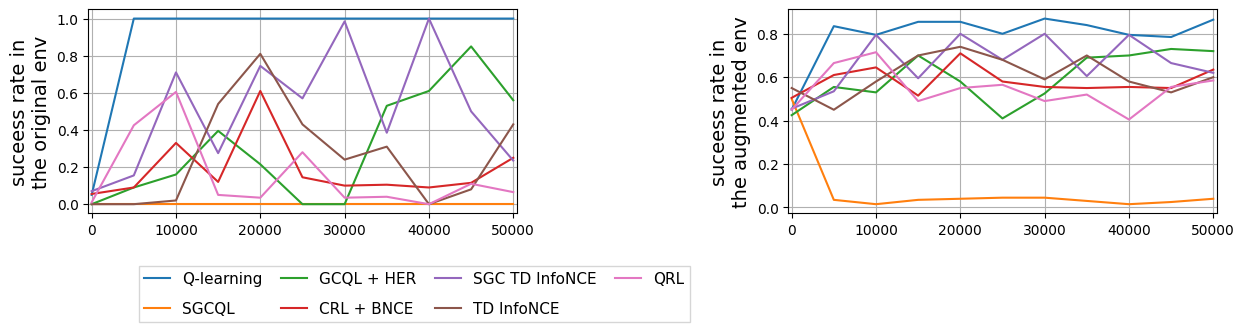

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3.2))

metric_name = 'eval/success_rate'
ax = axes[0]
for algo, metrics in zip(['Q-learning', 'SGCQL', 'GCQL + HER', 'CRL + BNCE', 'SGC TD InfoNCE', 'TD InfoNCE', 'QRL'], 
                         [q_learning_metrics, sgcql_metrics, gcql_her_metrics, crl_metrics, sgc_td_infonce_metrics, td_infonce_metrics, qrl_metrics]):
    metrcs_arr = np.asarray(metrics[metric_name])
    l, = ax.plot(metrcs_arr[:, 0], metrcs_arr[:, 1], label=algo, zorder=3)
ax.set_ylabel('suceess rate in\nthe original env', fontsize=14)
ax.set_xlim([-4e2, 5e4 + 4e2])
ax.legend(bbox_to_anchor=(0.1, -0.22),
          loc="upper left", labelspacing=1, columnspacing=1.2075, fancybox=False,
          shadow=False, fontsize=11, borderpad=0.35, handlelength=1.7, ncol=4)
ax.grid(zorder=3)

metric_name = 'eval/augmented_success_rate'
ax = axes[1]
for algo, metrics in zip(['Q-learning', 'SGCQL', 'GCQL + HER', 'CRL + BNCE', 'SGC TD InfoNCE', 'TD InfoNCE', 'QRL'], 
                         [q_learning_metrics, sgcql_metrics, gcql_her_metrics, crl_metrics, sgc_td_infonce_metrics, td_infonce_metrics, qrl_metrics]):
    metrcs_arr = np.asarray(metrics[metric_name])
    l, = ax.plot(metrcs_arr[:, 0], metrcs_arr[:, 1], label=algo, zorder=3)
ax.set_ylabel('suceess rate in\nthe augmented env', fontsize=14)
ax.set_xlim([-4e2, 5e4 + 4e2])
ax.grid(zorder=3)

# ax.set_ylim([-5, 120 + 5])
# ax.set_yticks([0, 120])
# ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.grid(zorder=3)     

fig.tight_layout(rect=(-0.026, -0.06, 1.02, 1.04))  # rect = (left, bottom, right, top), default: (0, 0, 1, 1)
# filepath = "/u/cz8792/research/ogbench/notebooks/figures/aug_env_lc.pdf"
filepath = "/home/cz8792/research/ogbench/notebooks/figures/aug_env_lc.pdf"
fig.savefig(filepath, dpi=150, bbox_inches="tight")
plt.show()
